# Polyhedra in input space (experiment)

Some useful links
* [Paper with the idea](https://arxiv.org/pdf/2306.17418)
* [Paper that make the toolbox](https://www.frontiersin.org/journals/big-data/articles/10.3389/fdata.2023.1274831/full#B10)
* [GitHub repository with code](https://github.com/cglrtrgy/GoL_Toolbox/tree/main)


This notebook is inspired by their [demo notebook](https://github.com/cglrtrgy/GoL_Toolbox/blob/main/Demo_V0.ipynb).


## Summary of core idea

## Dummy data and model

We use the `make_moons` dataset from `scikit-learn`:

In [33]:
import torch.nn as nn 
import torch
from sklearn.datasets import make_moons
import numpy as np
import matplotlib.pyplot as plt
from tqdm import trange

from src import functions
from src import trainer
from src import models

# Generate data
x, y = make_moons(1000, noise=0.1)
x, y = torch.tensor(x, dtype=torch.float), torch.tensor(y, dtype=torch.float)

# Useful function to convert tensors to numpy arrays
def to_np(x):
    return x.cpu().detach().numpy()

Train a simple binary classifier with ReLU activation on the two-moons dataset. 

100%|██████████| 5000/5000 [00:02<00:00, 1862.48it/s]


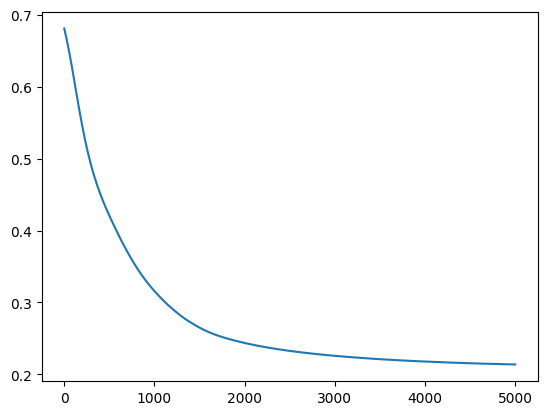

In [41]:
# Dummy model to test the functions
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()

        self.l1 = nn.Linear(2, 2)
        self.relu1 = nn.ReLU()
        self.l2 = nn.Linear(2, 3)
        self.relu2 = nn.ReLU()
        # self.l3 = nn.Linear(3, 3)
        # self.relu3 = nn.ReLU()
        self.out = nn.Linear(3, 1)

    def forward(self, x):

        out = x
        out = self.relu1(self.l1(out))
        out = self.relu2(self.l2(out))
        # out = self.relu3(self.l3(out))
        out = torch.sigmoid(self.out(out).squeeze())

        return out


# Train the model 

EPOCHS = 5000
criterion = nn.BCELoss()

model = MLP()
optimizer = torch.optim.Adam(model.parameters())
losses = []

for epoch in trange(EPOCHS):
    model.train()
    optimizer.zero_grad()

    out = model(x)
    loss = criterion(out, y)
    loss.backward()
    losses.append(loss.item())
    optimizer.step()

    optimizer.zero_grad()

plt.figure(1)
plt.plot(losses)
plt.show()


## 1 - Bit-vector

This is found using a random data point on a pre-trained model, and creating vector of the activations, 0 if 0 or 1 if activated. This is the same as taking the derivative of the activation and stacking them. 

In [43]:
model.eval()
# For random sample, just use first sample for now
random_sample = to_np(x[0].unsqueeze(0).T)
random_sample

array([[ 0.24883123],
       [-0.14185633]], dtype=float32)

In [46]:
# Get the bit vector. This will be a list of bit vectors, one for each sample, whose length is the number of ReLU activations in the model, stacked across layers.
bit_vector_of_sample  = functions.bit_vector_from_relus(model, random_sample, stack_layers = True, verbose=False, get_unique_bit_vectors_only=False)
print("Shape of the bit vector: ")
bit_vector_of_sample[0].shape
# print(bit_vector_of_an_image)

Shape of the bit vector: 


(5, 1)

In [53]:
# Get the same bit vectors, but without stacking across layers.
bit_vector_of_sample_no_stack  = functions.bit_vector_from_relus(model, random_sample, stack_layers = False, verbose=False, get_unique_bit_vectors_only=False)

In [54]:
counter = 1
for a_bit_vector in bit_vector_of_sample_no_stack[0]:
    print(f"Shape of the {counter}. hidden layer's bit vector: {a_bit_vector.shape}")
    counter += 1
    

Shape of the 1. hidden layer's bit vector: (2, 1)
Shape of the 2. hidden layer's bit vector: (3, 1)


In [58]:
print("Bit vector of the first sample:")
print(bit_vector_of_sample)
print("Bit vector of the first sample, without stacking across layers:")
print(bit_vector_of_sample_no_stack)

Bit vector of the first sample:
[array([[0],
       [1],
       [0],
       [1],
       [1]])]
Bit vector of the first sample, without stacking across layers:
[[array([[0],
       [1]]), array([[0],
       [1],
       [1]])]]


## 2 - Linear model for polyhedron